In [1]:
from helpers import *

In [2]:
%matplotlib inline

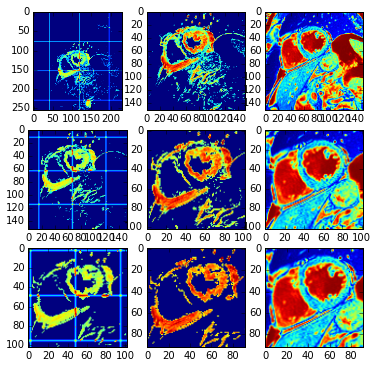

In [13]:
reductions = []
case = 1
patient, meta = all_slices(case, pix=True)
#Get the middle slice
num_layers = len(patient)
mid_layer = num_layers//2
mid_slice = patient[mid_layer]
patient = fix_contrast(np.array(patient))
mid_slice = patient[mid_layer]
reduction = 1
fig = plt.figure(figsize=(6,6))
for i in range(3):
    mid_slice_stfd = spatial_temporal_finite_difference(mid_slice)
    #mid_slice_stfd = fix_contrast(mid_slice_stfd) #TRY THIS
    mid_slice_stfd = threshold_std(mid_slice_stfd,1.)

    # blur
    result = cv2.GaussianBlur(mid_slice_stfd, (9, 9), 0)
    # get centroid
    row,col = get_centroid(result)
    # get roi
    rstart, rend, cstart, cend = bounding_square(result, row, col)
    width = rend-rstart

    mid_slice = map(lambda x: x[rstart:rend, cstart:cend], mid_slice)
    old_mid_slice_stfd = mid_slice_stfd.copy()
    mid_slice_stfd = mid_slice_stfd[rstart:rend,cstart:cend]
    #Fix contrast again
    #mid_slice = fix_contrast(np.array(mid_slice))
    #print 'Size reduction:', ((rend-rstart)**2)/float(result.size)
    reduction *= ((rend-rstart)**2)/float(result.size)
    rlm = line_mask(result, rstart, cstart)
    clm = line_mask(result, rend, cend)
    center = line_mask(result, row, col)
    plt.subplot(3,3,3*i+1)
    plt.imshow(rlm+ clm+center+old_mid_slice_stfd)
    plt.subplot(3,3,3*i+2)
    plt.imshow(mid_slice_stfd)
    plt.subplot(3,3,3*i+3)
    plt.imshow(mid_slice[0])
#fig.savefig(str(case))
#plt.close(fig)
reductions.append(reduction)


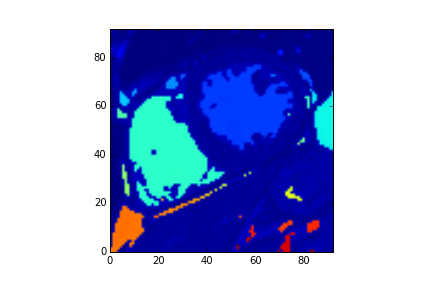
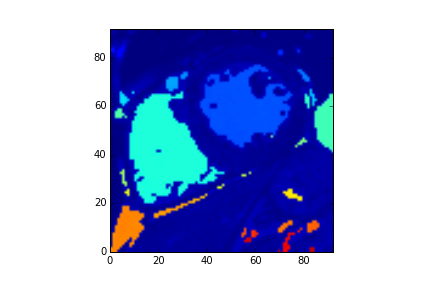
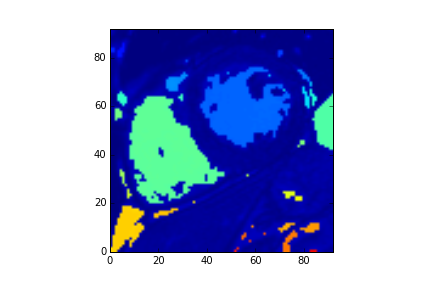
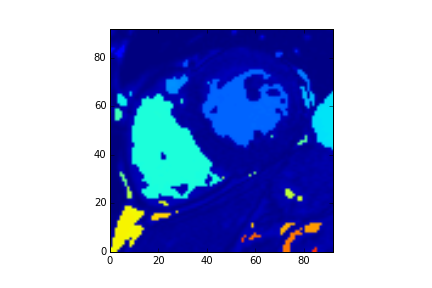
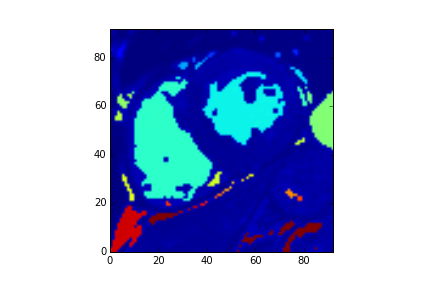
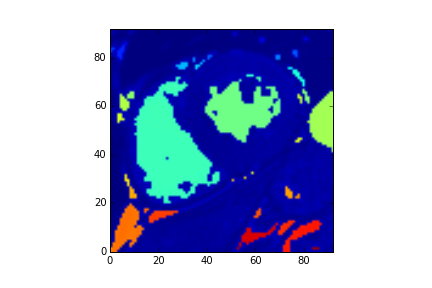
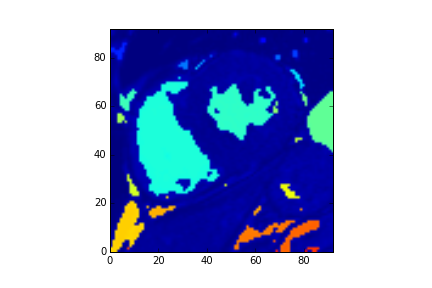
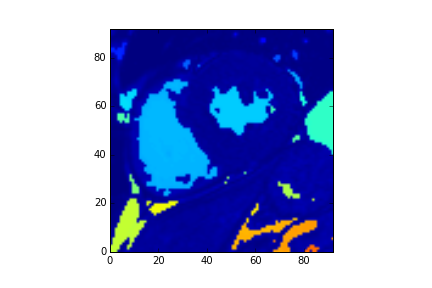
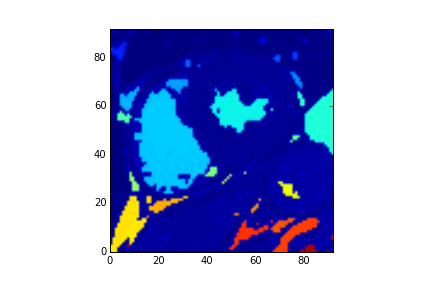
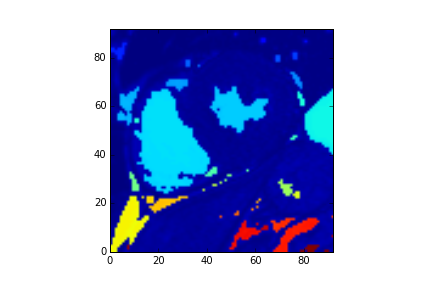
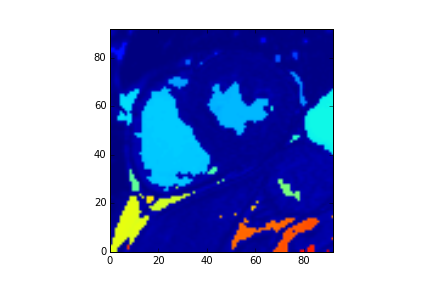
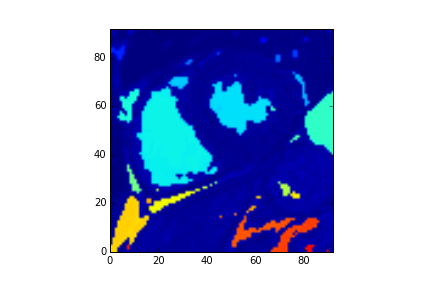
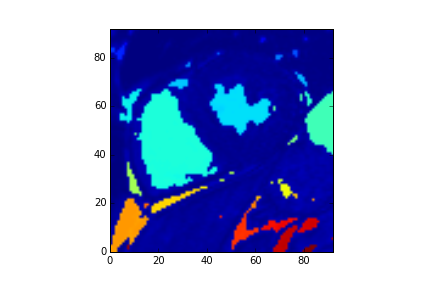
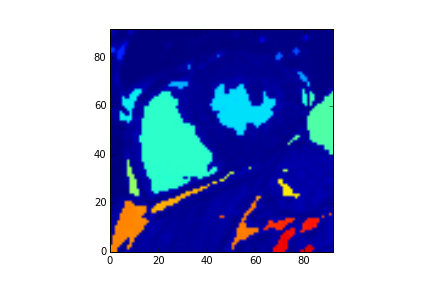
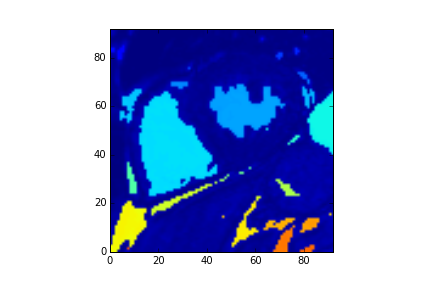
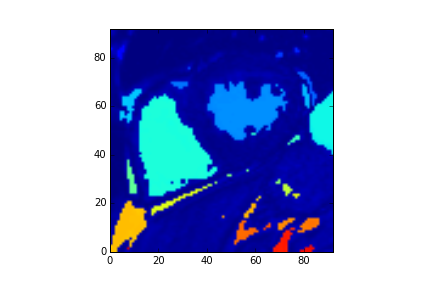
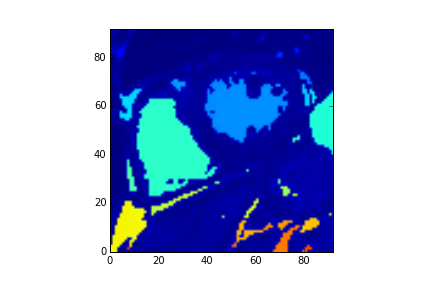
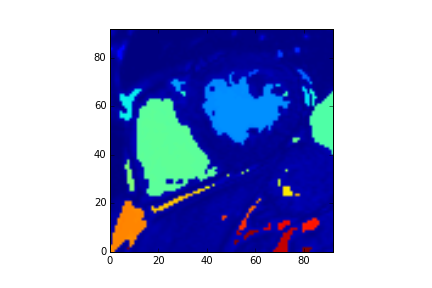
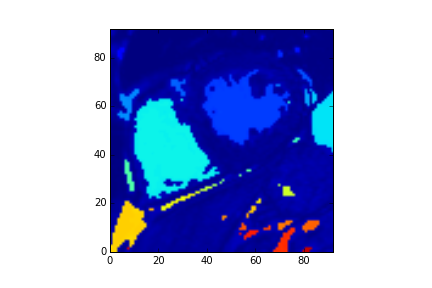
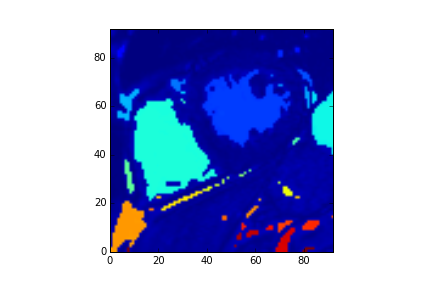
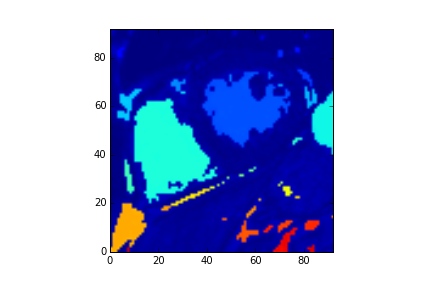
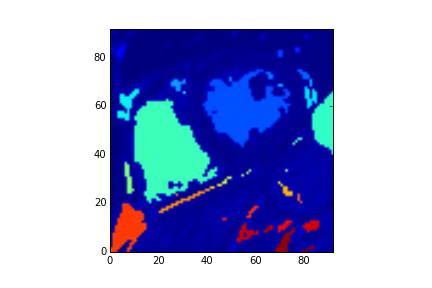
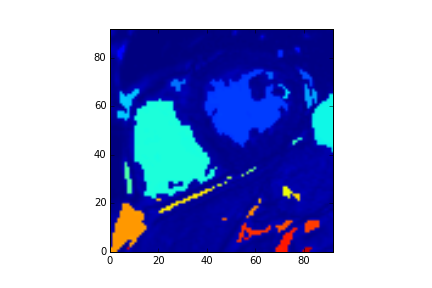
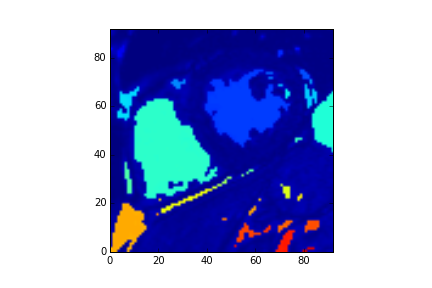
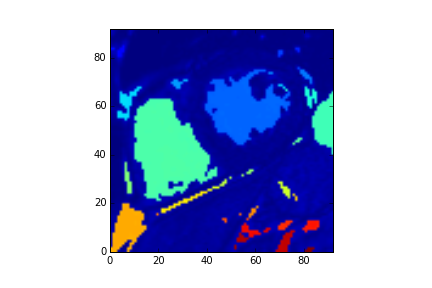
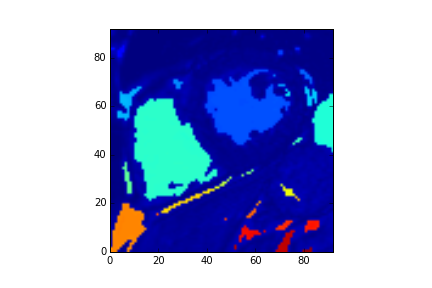
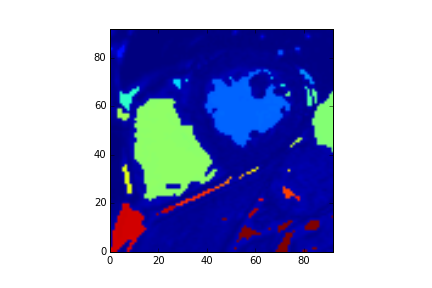
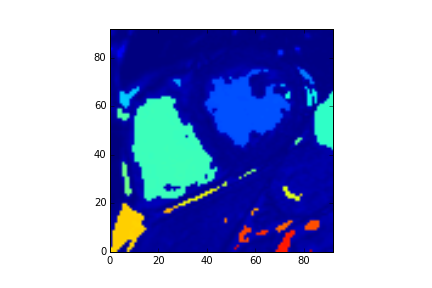
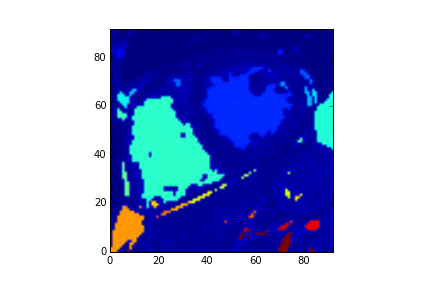
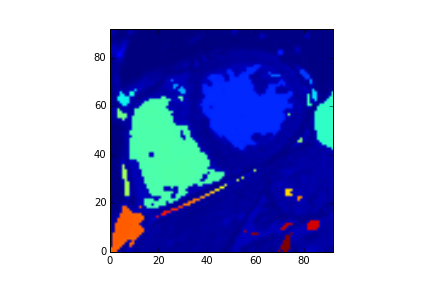

In [14]:
# get slice components
components = map(lambda i: filtered_components(mid_slice[i]), range(30))
#Unpack the components tuple
masks,areas,centroids = map(np.array, zip(*components))
animate([2*mid_slice[i]+components[i][0] for i in range(30)], None)

In [15]:
len(np.unique(components[0][0]))

48

In [16]:
mid_layer_stfd = spatial_temporal_finite_difference(patient[mid_layer])
prior = ndimage.gaussian_filter(mid_layer_stfd, GAUSSIAN_BLUR_PRE_CENTROID_STFD**2) #TODO: update this
# get tracks
track = np.zeros_like(patient)
# do middle layer
prop_through_space(track, patient, mid_layer, 0, prior=prior)

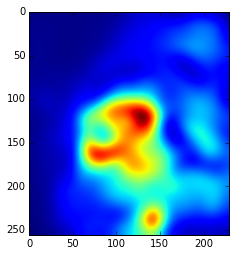

In [17]:
plt.imshow(prior)

In [32]:
track.shape

(13, 30, 256, 192)


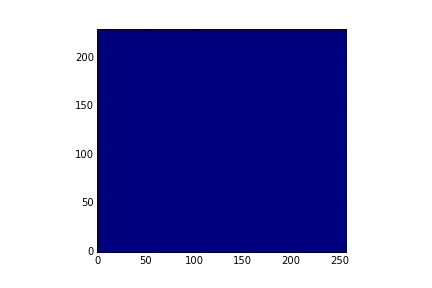
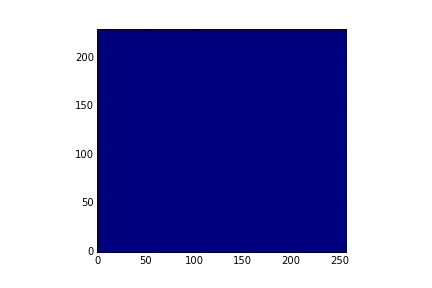
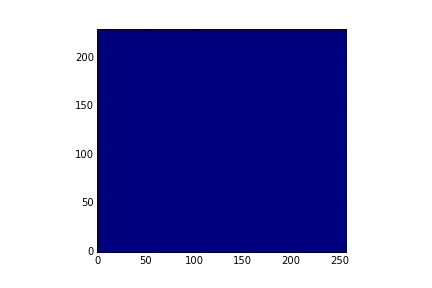
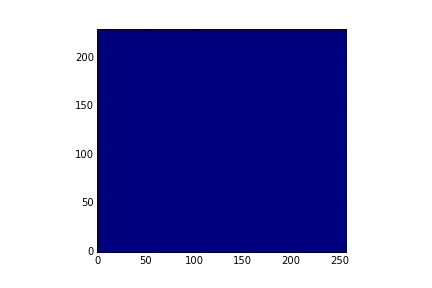
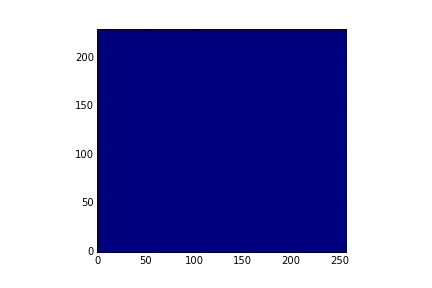
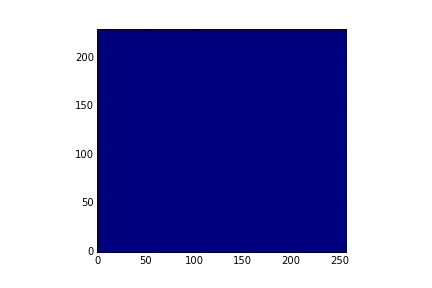
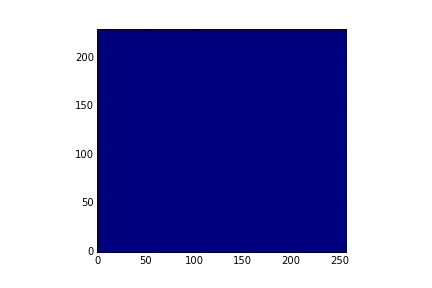
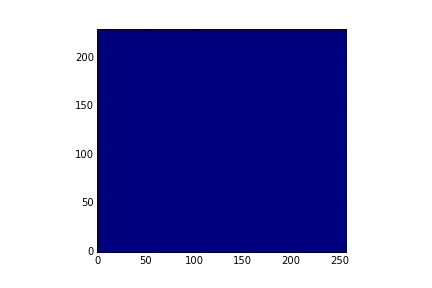
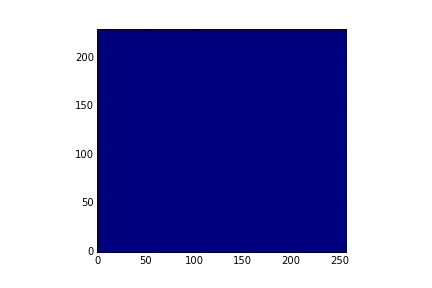
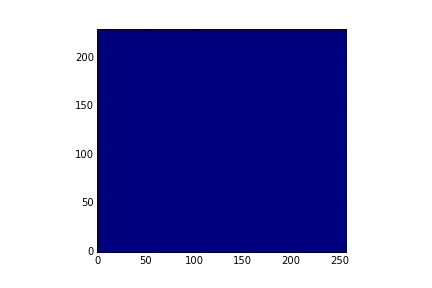
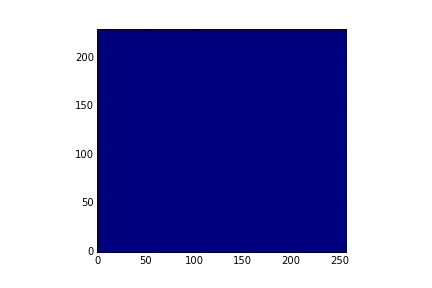
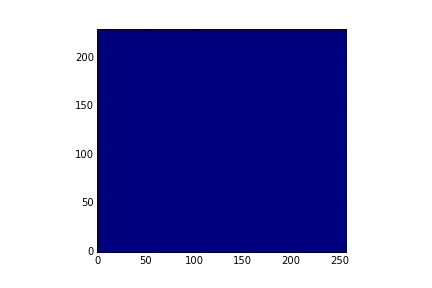
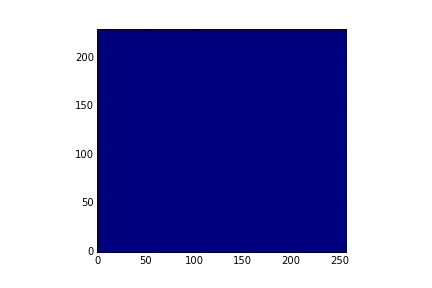
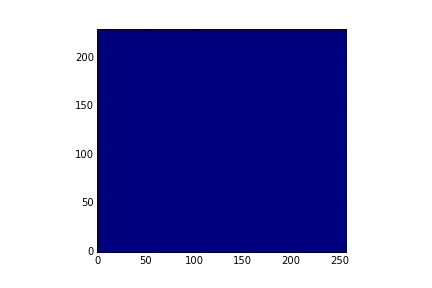
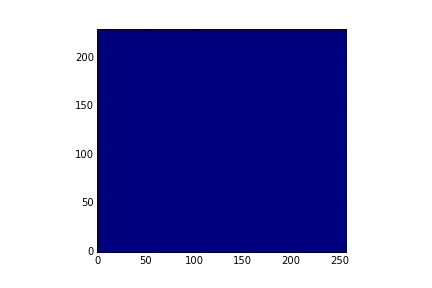
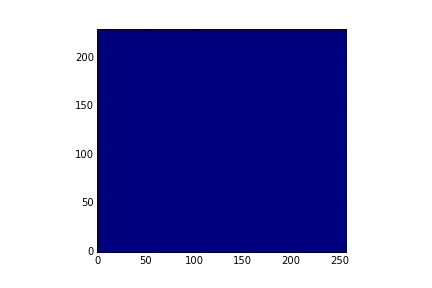
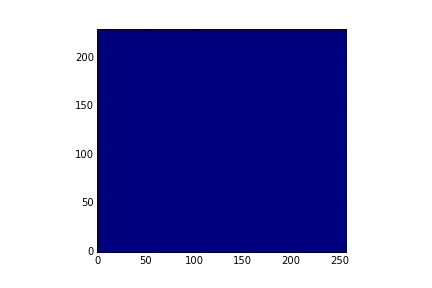
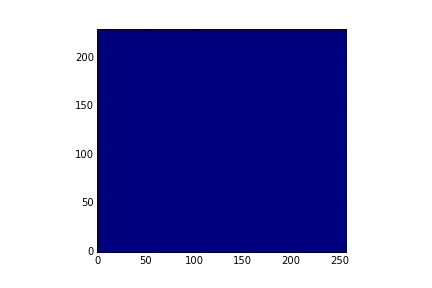
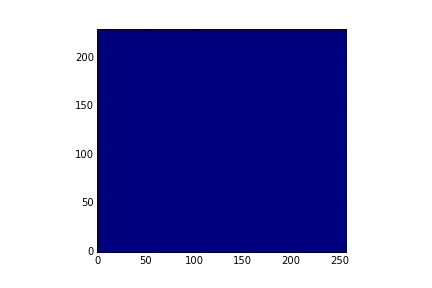
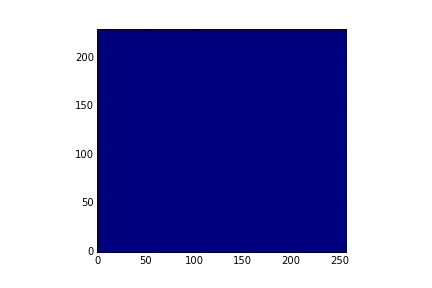
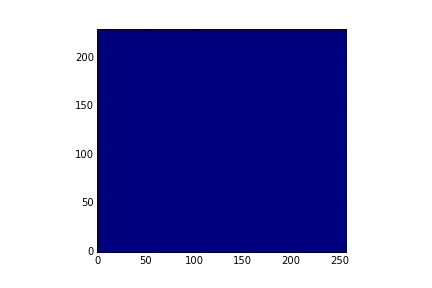
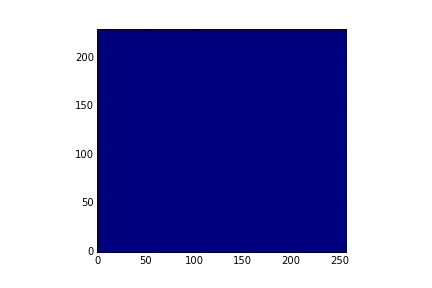
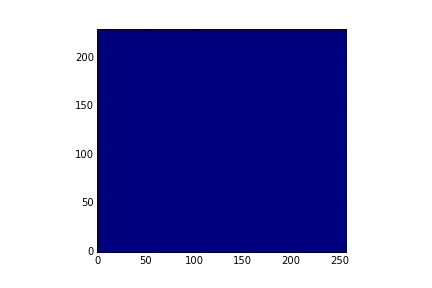
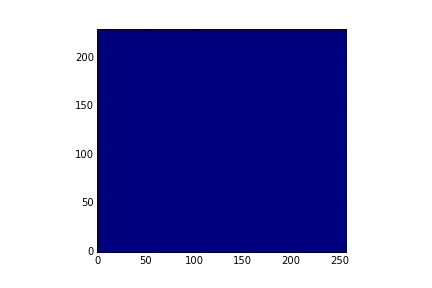
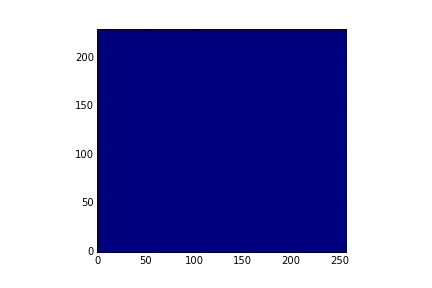
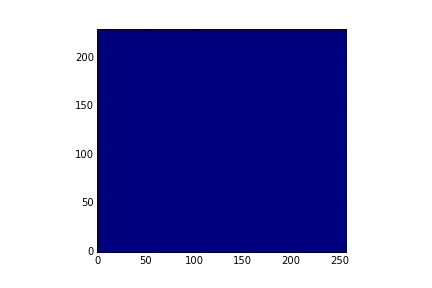
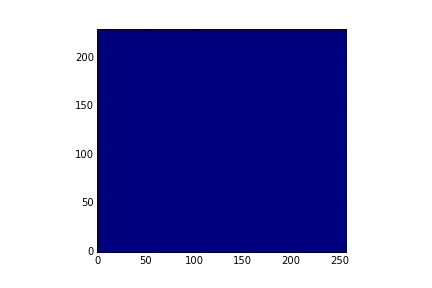
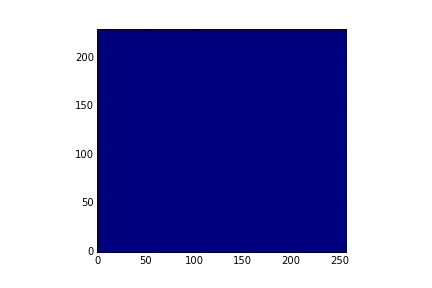
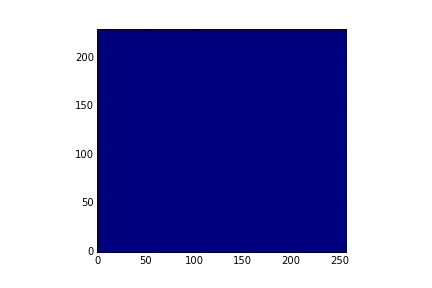
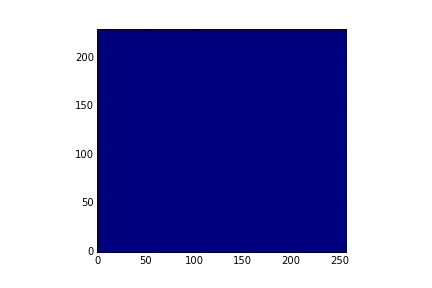

In [18]:
animate(track[mid_layer], None)

In [19]:
def fix_contrast(imgs):
    ''' imgs has dimensions (slices, time-frames, rows, cols)'''
    max_along_cols = np.max(np.reshape(imgs, (imgs.shape[0],imgs.shape[1],imgs.shape[2]*imgs.shape[3])), 2)
    max_along_rows = np.max(max_along_cols, 1)
    thresh = np.min(max_along_rows)
    return imgs*(imgs<thresh)

In [20]:
sys, dia, track = run_pipeline(6)
print sys, dia

13.806 18.756



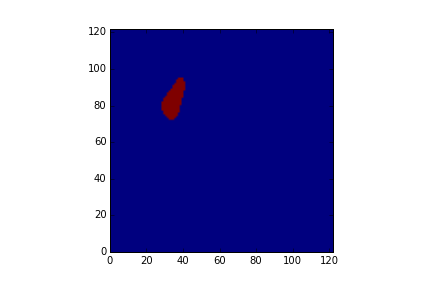
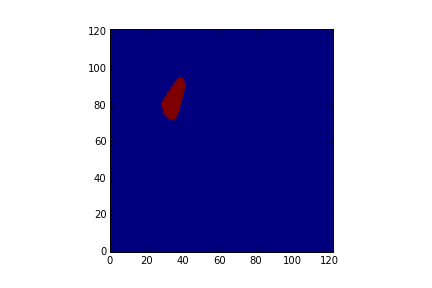
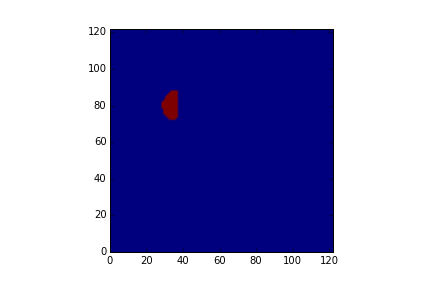
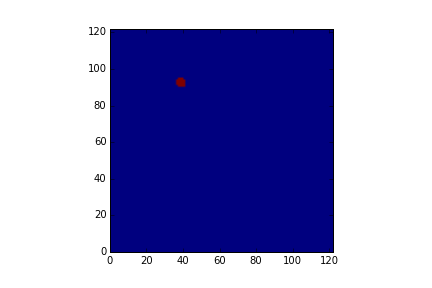
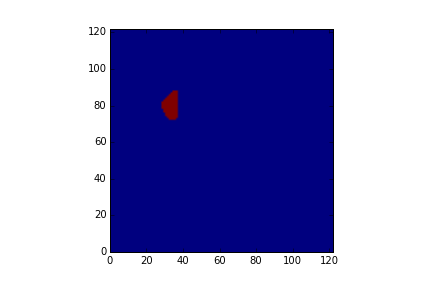
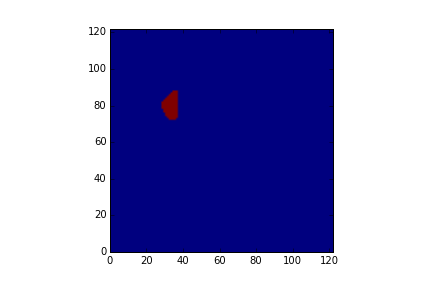
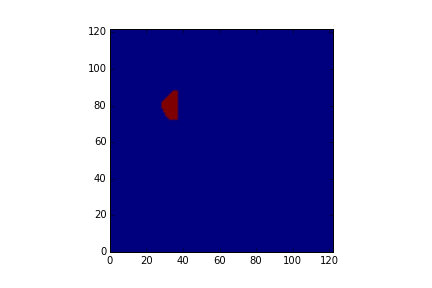
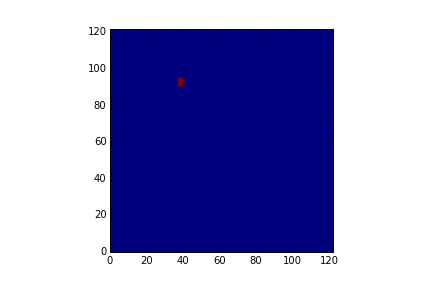
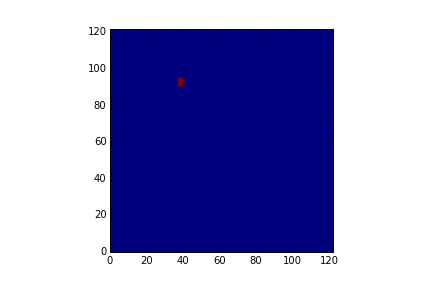
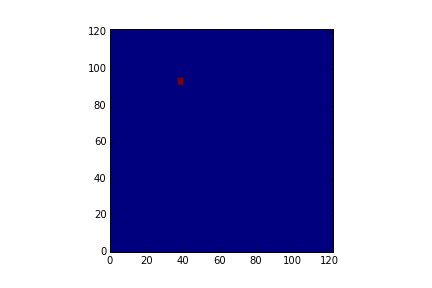
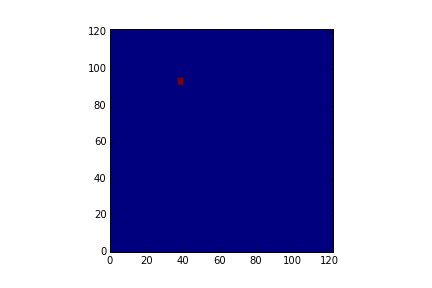
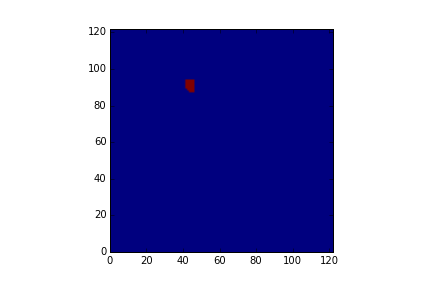
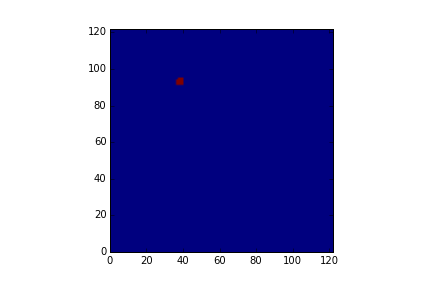
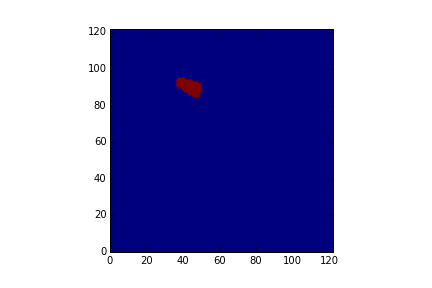
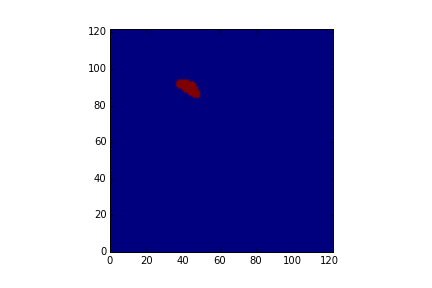
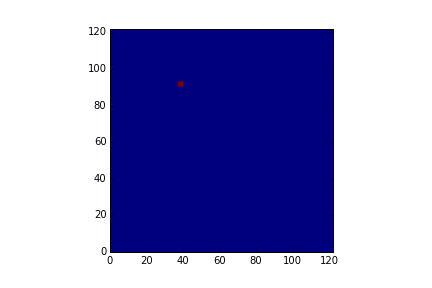
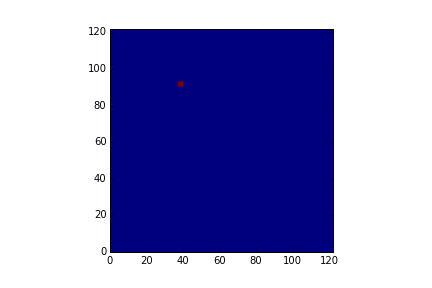
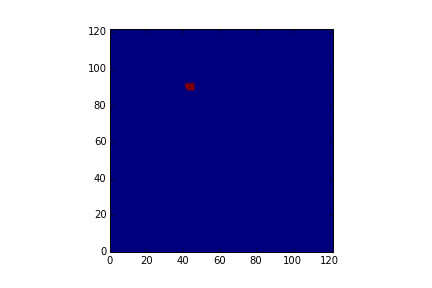
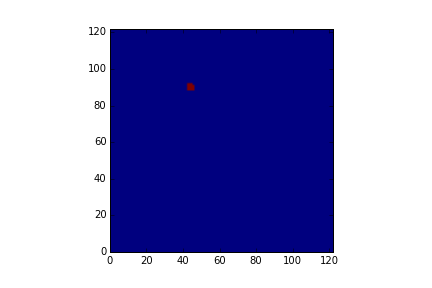
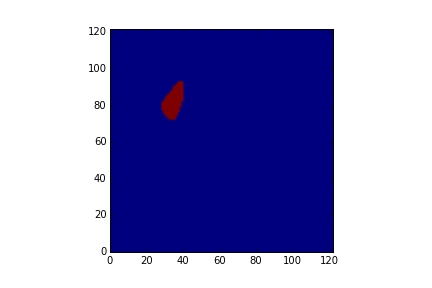
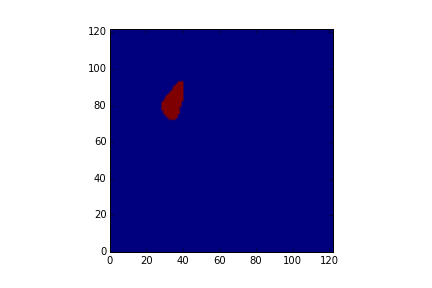
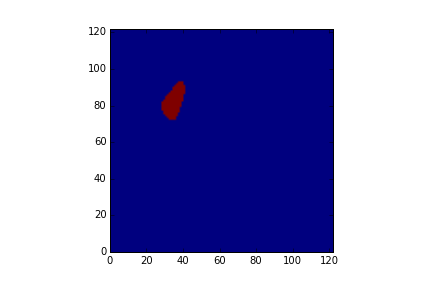
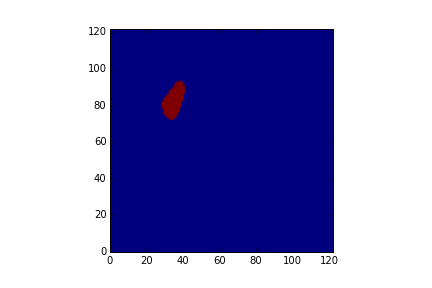
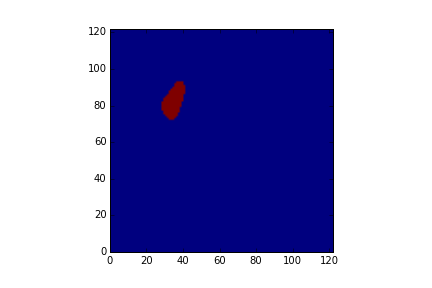
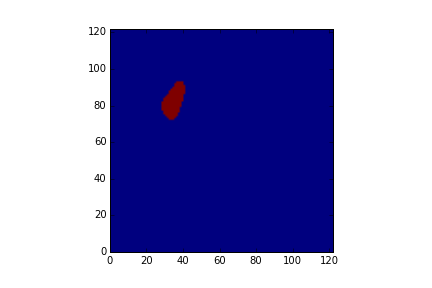
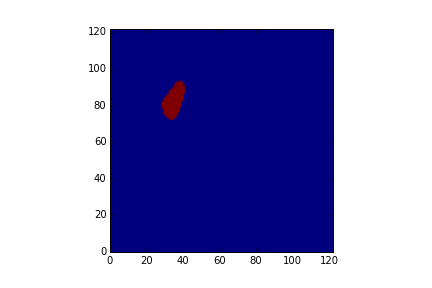
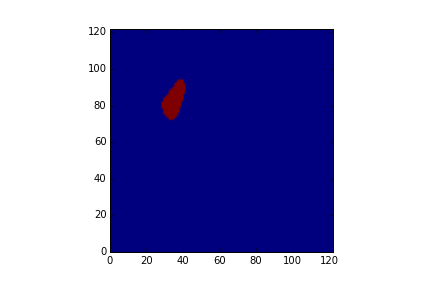
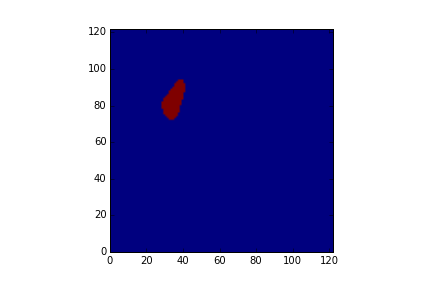
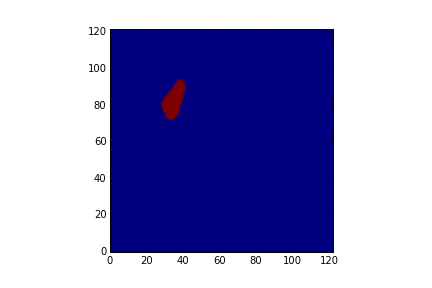
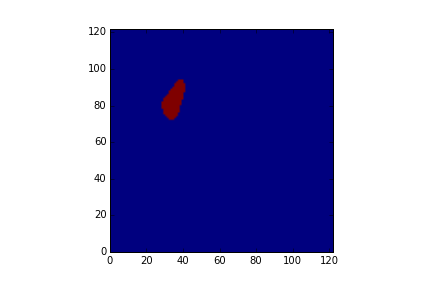

In [21]:
animate(track[track.shape[0]//2], None)

In [22]:
def fix_contrast(patient):
    return np.tanh((patient - patient.mean())/patient.std())

In [5]:
sys, dia, track = run_pipeline(1)
print sys, dia

45.7245 586.6695



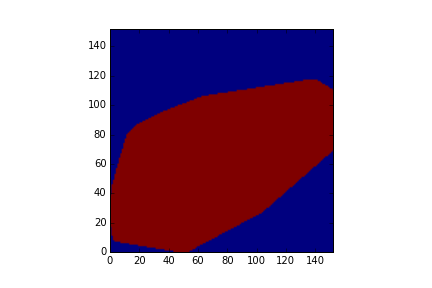
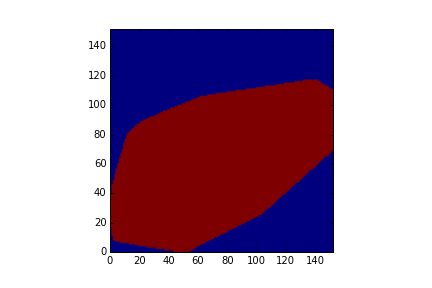
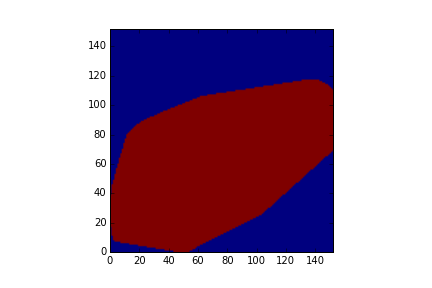
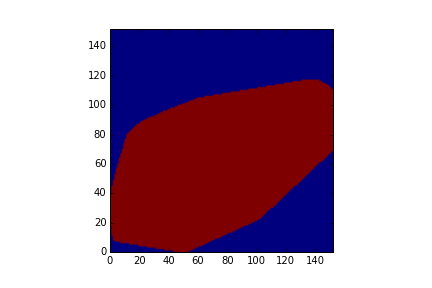
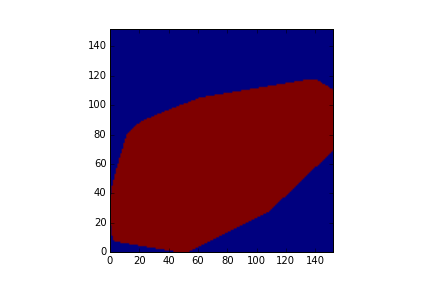
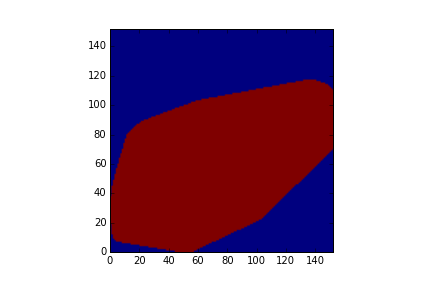
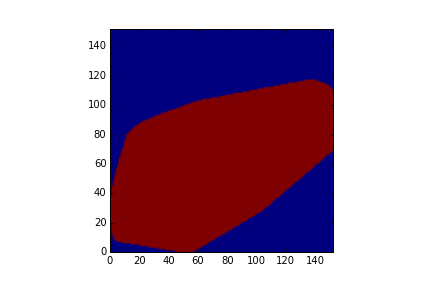
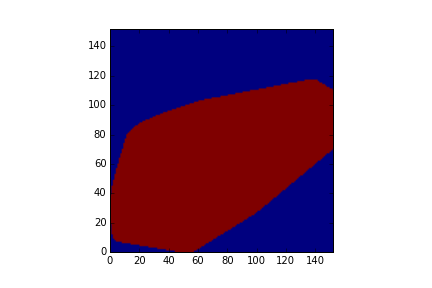
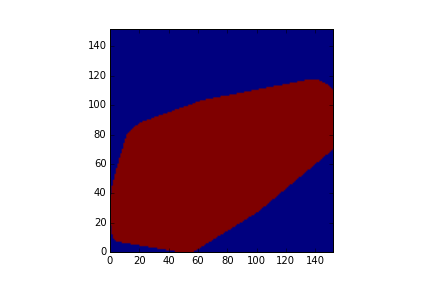
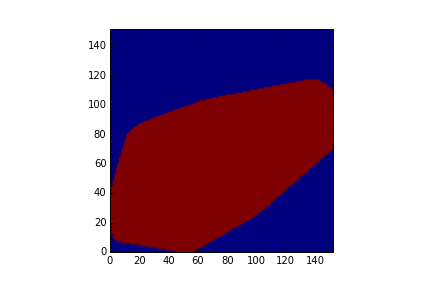
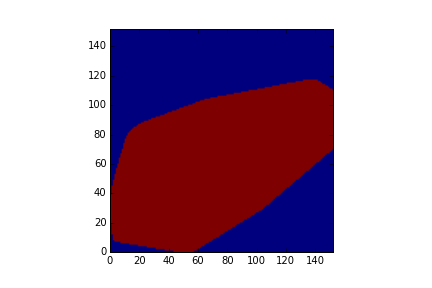
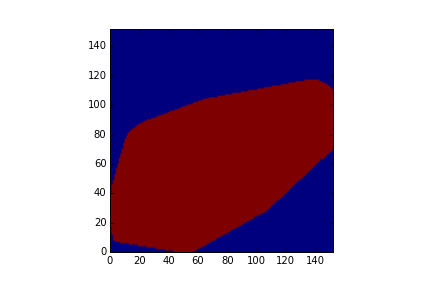
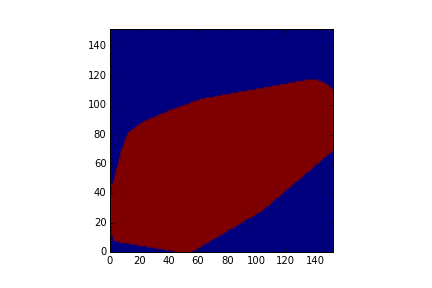
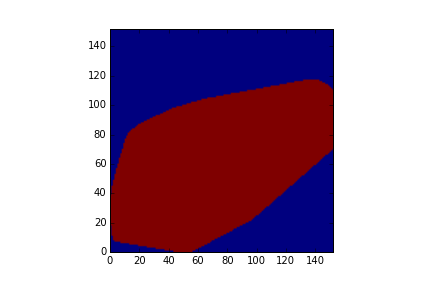
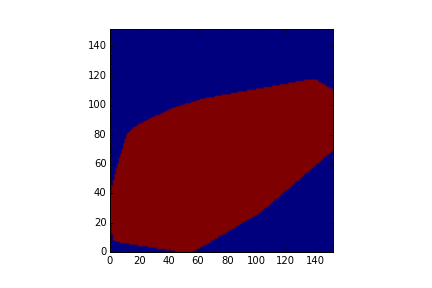
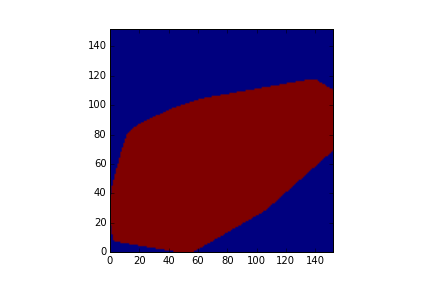
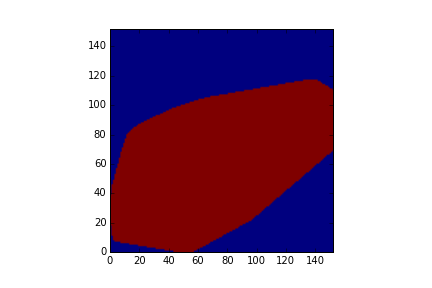
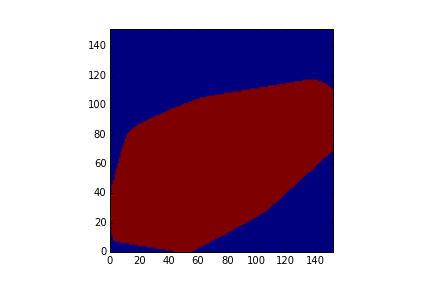
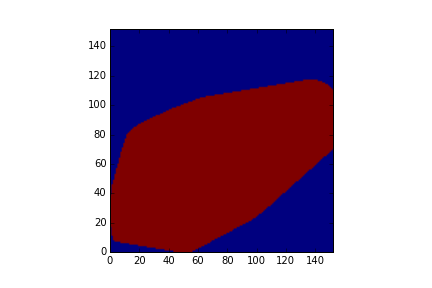
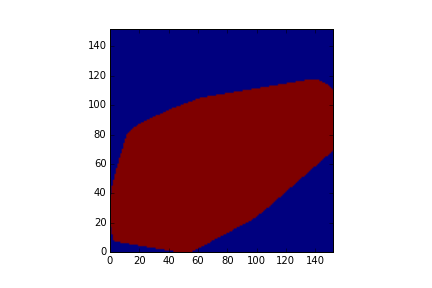
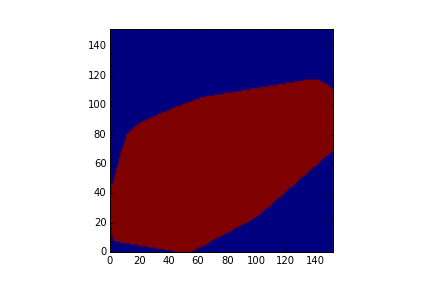
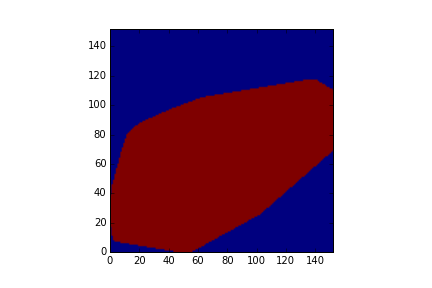
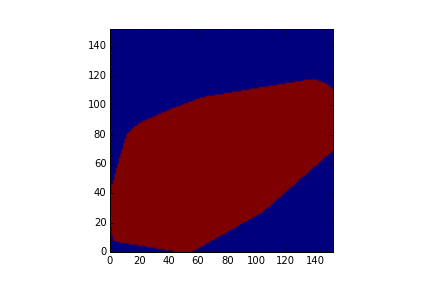
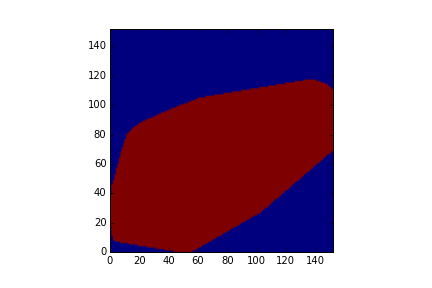
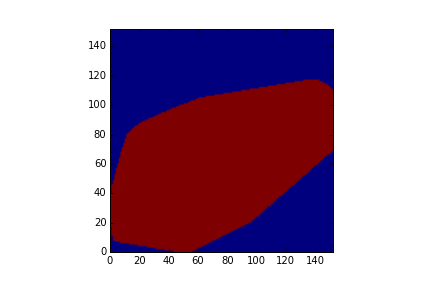
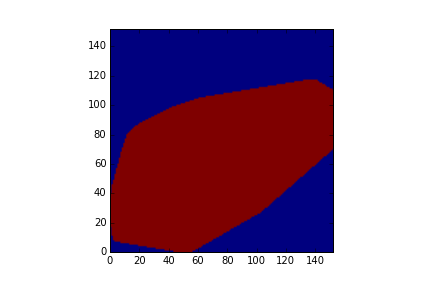
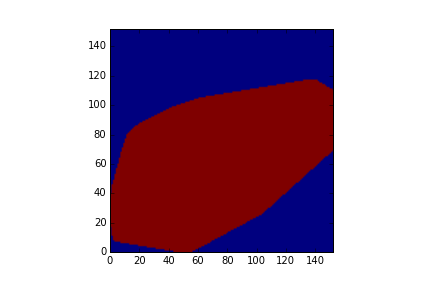
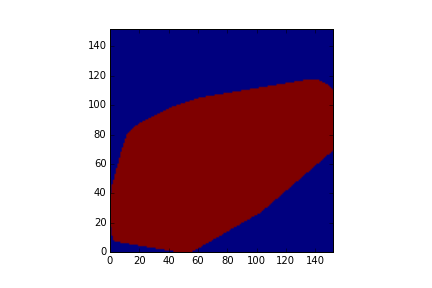
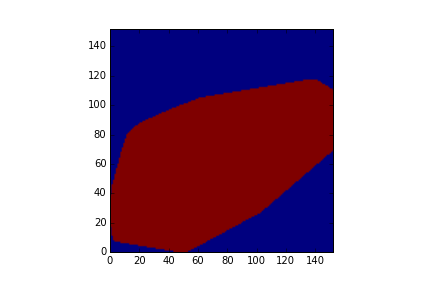
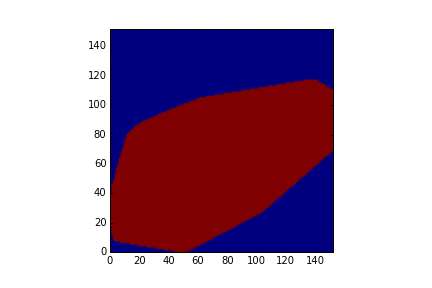

In [7]:
animate(track[0], None) #track.shape[0]//2

In [16]:
def curve_score(curve):
    '''Returns a score indicating how likely it is that a curve is correct (lower is better)'''
    ft = scipy.fft(curve)
    #ft *= ft #Power Spectral Density
    score = np.linalg.norm(ft[3:-2])/np.linalg.norm(ft[1:]) #lower is better
    return score

In [18]:
a = track.sum(2).sum(2)
num_times = track.shape[1]
a_interp = linear_interpolate(a, num_times)

[curve_score(c) for c in a]

[0.62927627849278112,
 0.11087888183106534,
 0.7059190435089806,
 0.20360687535503297,
 0.85094407769065805,
 0.16469158152466454,
 0.90428147661258473,
 0.8248568299825112,
 0.67951530741688992,
 0.46318202624929161,
 0.81194009628974839]